# Coverage of viral tags and barcodes by Illumina 10X reads
This Python Jupyter notebook examines where the 10X aligned FASTQ reads fall on the viral genes (coverage) with respect to viral barcodes and viral tags.
It also writes information on the locations of the viral barcodes and tags in the viral genes.

## Parameters
First, set the parameters for the notebook, such as to specify the input files and output plots.
This is done in the next cell, which is tagged as a `parameters` cell to enable [papermill parameterization](https://papermill.readthedocs.io/en/latest/usage-parameterize.html):

In [1]:
# parameters cell; in order for notebook to run this cell must define:
#  - samples_10x: list of 10X samples
#  - input_fastq10x_bams: list of BAM file with alignments of 10X reads for each sample
#  - input_fastq10x_bais: BAM indices for each file in `input_fastq10x_bam`
#  - input_viral_genbank: Genbank file with annotated viral genes
#  - output_viraltag_locs: output file with location of viral tags (1, ..., numbering)
#  - output_viralbc_locs: output file with location of viral barcodes (1, ..., numbering)


In [2]:
# Parameters
samples_10x = ["wt_virus_pilot"]
input_fastq10x_bams = ["results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam"]
input_fastq10x_bais = ["results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam.bai"]
input_viral_genbank = "data/flu_sequences/flu-CA09.gb"
output_viraltag_locs = "results/viral_fastq10x/viraltag_locs.csv"
output_viralbc_locs = "results/viral_fastq10x/viralbc_locs.csv"


Check input lists all the right length, then make dicts that map sample names to BAM and BAM index files:

In [3]:
assert len(samples_10x) == len(input_fastq10x_bams) == len(input_fastq10x_bais)

fastq10x_bams = dict(zip(samples_10x, input_fastq10x_bams))
fastq10x_bais = dict(zip(samples_10x, input_fastq10x_bais))

## Import Python modules
We use [pysam](https://pysam.readthedocs.io/) to plot process the BAM files, [dna_features_viewer](https://edinburgh-genome-foundry.github.io/DnaFeaturesViewer/) for genes, and [plotnine](https://plotnine.readthedocs.io/) for some ggplot2-style plotting:

In [4]:
import collections
import itertools

import Bio.SeqIO

from IPython.display import display, HTML

import mizani

import pandas as pd

from plotnine import *

import pysam

Color-blind palette:

In [5]:
cbpalette = ('#999999', '#E69F00', '#56B4E9', '#009E73',
             '#F0E442', '#0072B2', '#D55E00', '#CC79A7')

Set [plotnine theme](https://plotnine.readthedocs.io/en/stable/api.html#themes):

In [6]:
_ = theme_set(theme_classic)

## Read the viral genes
Get all the viral genes as [BioPython SeqRecords](https://biopython.org/wiki/SeqRecord):

In [7]:
print(f"Reading viral genes from {input_viral_genbank}")
viral_genes = list(Bio.SeqIO.parse(input_viral_genbank, 'genbank'))
viral_gene_names = [s.id for s in viral_genes]
print(f"Found {len(viral_gene_names)} viral genes:\n\t" +
      '\n\t'.join(viral_gene_names))
assert len(viral_genes) == len(set(viral_gene_names)), 'viral gene names not unique'

Reading viral genes from data/flu_sequences/flu-CA09.gb
Found 8 viral genes:
	fluPB2
	fluPB1
	fluPA
	fluHA
	fluNP
	fluNA
	fluM
	fluNS


## Get viral tag and barcode locations
Get the locations of the viral tags and barcodes for each gene in 1-based indexing inclusive of the first and last number (so the type of numbering that Genbank files use):

In [8]:
viraltag_df = []
viralbc_df = []
for seqrecord in viral_genes:
    for f in seqrecord.features:
        if f.type == 'viral_barcode':
            viralbc_df.append([seqrecord.id, int(f.location.start) + 1, int(f.location.end)])
        elif 'tag' in f.type:
            viraltag_df.append((seqrecord.id, f.type, int(f.location.start) + 1, int(f.location.end)))
            
viraltag_df = pd.DataFrame.from_records(viraltag_df,
                                        columns=['gene', 'tag_name', 'start', 'end'])
assert len(viraltag_df) == len(viraltag_df.drop_duplicates())
print(f"\nViral tag locations; writing to {output_viraltag_locs}")
viraltag_df.to_csv(output_viraltag_locs, index=False)
display(HTML(viraltag_df.to_html(index=False)))

viralbc_df = pd.DataFrame.from_records(viralbc_df,
                                       columns=['gene', 'start', 'end'])
assert len(viralbc_df) == len(viralbc_df.drop_duplicates())
print(f"\nViral barcode locations; writing to {output_viralbc_locs}")
viralbc_df.to_csv(output_viralbc_locs, index=False)
display(HTML(viralbc_df.to_html(index=False)))


Viral tag locations; writing to results/viral_fastq10x/viraltag_locs.csv


gene,tag_name,start,end
fluPB2,viral_tag_1,201,201
fluPB2,viral_tag_2,2190,2190
fluPB1,viral_tag_1,192,192
fluPB1,viral_tag_2,2205,2205
fluPA,viral_tag_1,123,123
fluPA,viral_tag_2,2104,2104
fluHA,viral_tag_1,249,249
fluHA,viral_tag_2,1686,1686
fluNP,viral_tag_1,132,132
fluNP,viral_tag_2,1407,1407



Viral barcode locations; writing to results/viral_fastq10x/viralbc_locs.csv


gene,start,end
fluHA,1828,1843
fluNA,1551,1566


## Get alignment statistics for each gene and sample
Use [pysam](https://pysam.readthedocs.io/) to get the following dataframes:
 - `nreads_df`: total number of reads aligned to each gene in each sample
 - `coverage_df`: coverage at each site for each viral gene in each sample
 - `readlen_df`: distribution of lengths of the **aligned** portion of reads (not including soft-clipped bases) for each gene in each sample

In [9]:
coverage_list = []
nreads_list = []
readlen_list = []

for viral_gene, sample10x in itertools.product(viral_genes, samples_10x):
    gene_name = viral_gene.id
    bam = fastq10x_bams[sample10x]
    bai = fastq10x_bais[sample10x]
    print(f"Getting statistics for {gene_name} in {sample10x} from {bam}")
    
    with pysam.AlignmentFile(bam, mode='rb', index_filename=bai) as bamfile:
        if len(viral_gene) != bamfile.get_reference_length(gene_name):
            raise ValueError(f"length of {gene_name} not as expected in {bam}")
            
        nreads_list.append(
                pd.DataFrame({'gene': [gene_name],
                              'sample': [sample10x],
                              'nreads': [bamfile.count(contig=gene_name)],
                              })
                ) 

        coverage_list.append(
                pd.DataFrame(dict(zip('ACGT',
                                      bamfile.count_coverage(contig=gene_name))))
                .assign(coverage=lambda x: x.sum(axis=1),
                        site=lambda x: x.index + 1,
                        gene=gene_name,
                        sample=sample10x)
                [['gene', 'sample', 'site', 'coverage']]
                )
        
        readlens = collections.defaultdict(int)
        for read in bamfile.fetch(contig=gene_name):
            readlens[read.query_alignment_length] += 1
        readlen_list.append(
                pd.DataFrame.from_records(list(readlens.items()),
                                          columns=['aligned_read_length', 'nreads'])
                .assign(gene=gene_name,
                        sample=sample10x)
                .sort_values('aligned_read_length')
                [['gene', 'sample', 'aligned_read_length', 'nreads']]
                )
        
nreads_df = (pd.concat(nreads_list, sort=False, ignore_index=True)
             .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                   viral_gene_names,
                                                   ordered=True))
             )
print('\nFirst few lines of `nreads_df`:')
display(HTML(nreads_df.head().to_html(index=False)))
        
coverage_df = (pd.concat(coverage_list, sort=False, ignore_index=True)
               .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                     viral_gene_names,
                                                     ordered=True))
               )
print('\nFirst few lines of `coverage_df`:')
display(HTML(coverage_df.head().to_html(index=False)))

readlen_df = (pd.concat(readlen_list, sort=False, ignore_index=True)
              .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                    viral_gene_names,
                                                    ordered=True))
              )
print('\nFirst few lines of `readlen_df`:')
display(HTML(readlen_df.head().to_html(index=False)))

Getting statistics for fluPB2 in wt_virus_pilot from results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam
Getting statistics for fluPB1 in wt_virus_pilot from results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam
Getting statistics for fluPA in wt_virus_pilot from results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam
Getting statistics for fluHA in wt_virus_pilot from results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam
Getting statistics for fluNP in wt_virus_pilot from results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam
Getting statistics for fluNA in wt_virus_pilot from results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam
Getting statistics for fluM in wt_virus_pilot from results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam
Getting statistics for fluNS in wt_virus_pilot from results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam

First few lines of `nr

gene,sample,nreads
fluPB2,wt_virus_pilot,2311
fluPB1,wt_virus_pilot,6512
fluPA,wt_virus_pilot,2042
fluHA,wt_virus_pilot,14763
fluNP,wt_virus_pilot,46120



First few lines of `coverage_df`:


gene,sample,site,coverage
fluPB2,wt_virus_pilot,1,34
fluPB2,wt_virus_pilot,2,90
fluPB2,wt_virus_pilot,3,87
fluPB2,wt_virus_pilot,4,91
fluPB2,wt_virus_pilot,5,89



First few lines of `readlen_df`:


gene,sample,aligned_read_length,nreads
fluPB2,wt_virus_pilot,81,31
fluPB2,wt_virus_pilot,82,24
fluPB2,wt_virus_pilot,83,17
fluPB2,wt_virus_pilot,84,9
fluPB2,wt_virus_pilot,85,8


Sanity check to make sure we got the right number of sites for each gene in `coverage_df`:

In [10]:
for viral_gene in viral_genes:
    gene_name = viral_gene.id
    lengths = (coverage_df
               .query('gene == @gene_name')
               .groupby('sample')
               .size()
               .values
               )
    if not all(lengths == len(viral_gene)):
        raise ValueError(f"coverage not for expected number sites for {gene_name}")

Sanity check to make sure `nreads_df` and `readlen_df` have same number of reads:

In [11]:
nreads_n = nreads_df.sort_values(['gene', 'sample'])['nreads'].values
readlen_n = (readlen_df
             .groupby(['gene', 'sample'])
             .aggregate({'nreads': 'sum'})
             ['nreads']
             .values
             )
if not all(nreads_n == readlen_n):
    raise ValueError('nreads differ for `nreads_df` and `readlen_df`')

## Total reads per viral gene
Plot the total number of aligned reads for each viral gene:

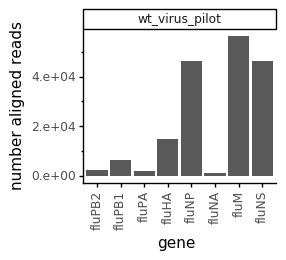

In [12]:
p = (ggplot(nreads_df, aes('gene', 'nreads')) +
     geom_bar(stat='identity') +
     facet_wrap('~ sample', nrow=1) +
     theme(figure_size=(2.5 * len(samples_10x), 2),
           axis_text_x=element_text(angle=90)) +
     scale_y_continuous(labels=mizani.formatters.scientific_format(),
                        name='number aligned reads')
     )

_ = p.draw()

## Lengths of aligned reads for each viral gene
Plot the distribution of the lengths of the **aligned** portions of each read for each viral gene:

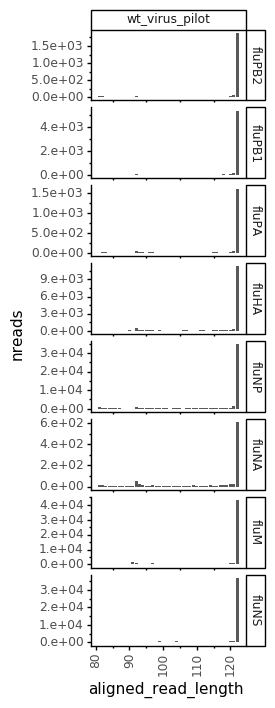

In [13]:
p = (ggplot(readlen_df, aes('aligned_read_length', 'nreads')) +
     geom_bar(stat='identity') +
     facet_grid('gene ~ sample', scales='free_y') +
     theme(figure_size=(2 * len(samples_10x), 1 * len(viral_gene_names)),
           axis_text_x=element_text(angle=90)) +
     scale_y_continuous(labels=mizani.formatters.scientific_format())
     )

_ = p.draw()

## Coverage per site, including over viral tags and barcodes
Now plot coverage per site alongside gene structure.
In this plot, we indicate the viral tags (blue) and viral barcodes (orange):

In [57]:
import itertools
import re

import dna_features_viewer

import matplotlib
import matplotlib.pyplot as plt

cbpalette = ('#999999', '#E69F00', '#56B4E9', '#009E73',
             '#F0E442', '#0072B2', '#D55E00', '#CC79A7')

def plot_genes_and_coverage(genes,
                            coverage_df,
                            *,
                            genes_relheight=0.3,
                            gene_features={'exon': '#999999', 
                                           'viral_barcode': '#E69F00',
                                           'viral_tag': '#56B4E9',
                                           },
                            full_gene_feature='exon',
                            site_tick_interval=250,
                            ):
    """Plot gene structure and coverage for one or more samples.
    
    Parameters
    -----------
    genes : list
        `BioPython SeqRecord <https://biopython.org/wiki/SeqRecord>`_ for each gene.
    coverage_df : pandas.DataFrame
        Gives coverage at each site. Must have columns 'gene', 'sample', 'site', and
        'coverage'. The entries in the 'gene' column should match the `id` attributes
        of the SeqRecords in `genes`. Sites should be in 1, ... numbering.
    genes_relheight : float
        Relative height of top row with genes relative to coverage plots.
    gene_features : dict
        Which features in `genes` to plot. Keyed by regular expressions strings that match
        `type` attributes of the SeqRecords in `genes`; values are colors for plotting.
        Features with types not in `gene_features` are not plotted.
    full_gene_feature : str
        Name of feature in each gene that represents the full gene length. Must be in
        `gene_features` too.
    site_tick_interval : int
        Frequency of ticks on x-axis giving site numbers.
    
    Returns
    --------
    matplotlib.figure.Figure, matplotlib.axes.Axes
        The figure and axes grid.
    
    """
    # check validity of genes and coverage
    gene_names = {gene.id for gene in genes}
    if len(genes) != len(set(gene_names)):
        raise ValueError('genes in `genes` do not have unique IDs')
    if set(coverage_df['gene']) != set(gene_names):
        raise ValueError('`coverage_df` and `genes` do not have same sets of genes')
    
    # set up grid of subplots
    gene_lengths = [len(gene) for gene in genes]
    samples = list(coverage_df['sample'].unique())
    fig, axes = plt.subplots(
                    nrows=1 + len(samples),
                    ncols=len(genes),
                    sharex='col',
                    gridspec_kw={'width_ratios': gene_lengths,
                                 'height_ratios': [genes_relheight] + [1] * len(samples)},
                    figsize=(16, 1.5 * (len(samples) + genes_relheight) + 1.5),
                    squeeze=False,
                    )

    # Convert genes to plottable graphic records
    class ViralGeneTranslator(dna_features_viewer.BiopythonTranslator):
        """Translate BioPython SeqRecord into GraphicRecord.""" 
        def compute_feature_color(self, feature):
            for regex, color in gene_features.items():
                if re.search(regex, feature.type):
                    return color

        def compute_feature_label(self, feature):
            return None
    
        def compute_filtered_features(self, features):
            return [f for f in features if
                    any(re.search(regex, f.type) for regex in gene_features.keys())]
    
    # plot the genes in the first row of the subplots
    for ax, seqrecord in zip(axes[: 1,].ravel(), genes):
        graphic_record = ViralGeneTranslator().translate_record(seqrecord)
        for f in graphic_record.features:
            f.linecolor = f.color
        graphic_record.plot(ax=ax, with_ruler=False, draw_line=False)
        ax.set_title(seqrecord.id, fontsize=15)

    # plot coverage on subplots not in first row
    full_gene_feature_regex = [regex for regex in gene_features.keys()
                               if re.search(regex, full_gene_feature)]
    if len(full_gene_feature_regex) != 1:
        raise ValueError('could not find `full_gene_feature` in `gene_features`')
    else:
        full_gene_feature_regex = full_gene_feature_regex[0]
    for ax, (sample, seqrecord) in zip(axes[1:,].ravel(),
                                  itertools.product(samples, genes)):
    
        gene = seqrecord.id
        # plot coverage over full gene
        df = coverage_df.query('(sample == @sample) & (gene == @gene)')
        df.plot(ax=ax,
                x='site',
                y='coverage',
                kind='area',
                legend=False,
                color=gene_features[full_gene_feature_regex],
                )
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0), useMathText=True)
        if sample == samples[-1]:
            xticklocs = list(range(1, int(ax.get_xlim()[1]), site_tick_interval))
            ax.set_xticks(ticks=xticklocs)
            ax.tick_params(axis='x', labelrotation=90)
        else:
            ax.set_xticklabels([])

        # plot rectangles for features of interest
        ymin, ymax = ax.get_ylim()
        for f in seqrecord.features:
            for regex, color in gene_features.items():
                if re.search(regex, f.type) and regex != full_gene_feature_regex:
                    break
            else:
                continue
            start = f.location.start
            end = f.location.end
            rect = matplotlib.patches.Rectangle(
                                xy=(start - 0.5, ymin),
                                width=end - start + 1,
                                height=ymax,
                                color=color,
                                zorder=4,
                                alpha=0.4)
            ax.add_patch(rect)
        
    # shared x- and y-labels following here: https://stackoverflow.com/a/53172335
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel('\nsite', size=14)
    plt.ylabel('coverage          ', size=14)
    
    # add legend for features
    plt.legend(handles=[matplotlib.patches.Patch(facecolor=color,
                                                 edgecolor=color,
                                                 label=regex)
                        for regex, color in gene_features.items()
                        if regex != full_gene_feature_regex],
               bbox_to_anchor=(1.005, ((len(samples) + 0.5 * genes_relheight) /
                                       (len(samples) + genes_relheight))),
               bbox_transform=plt.gcf().transFigure,
               fontsize=13,
               handlelength=0.5,
               )
    
    fig.tight_layout(w_pad=0)
    return fig, axes

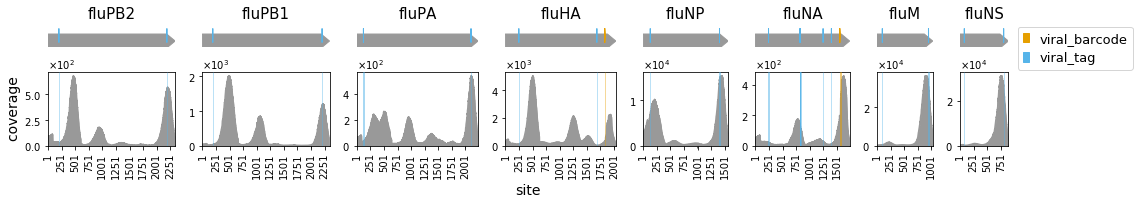

In [58]:
fig, _ = plot_genes_and_coverage(viral_genes, coverage_df)
display(fig)
plt.close(fig)

In [17]:
?plt.legend

Signature: plt.legend(*args, **kwargs)
Docstring:
Place a legend on the axes.

Call signatures::

    legend()
    legend(labels)
    legend(handles, labels)

The call signatures correspond to three different ways how to use
this method.

**1. Automatic detection of elements to be shown in the legend**

The elements to be added to the legend are automatically determined,
when you do not pass in any extra arguments.

In this case, the labels are taken from the artist. You can specify
them either at artist creation or by calling the
:meth:`~.Artist.set_label` method on the artist::

    line, = ax.plot([1, 2, 3], label='Inline label')
    ax.legend()

or::

    line, = ax.plot([1, 2, 3])
    line.set_label('Label via method')
    ax.legend()

Specific lines can be excluded from the automatic legend element
selection by defining a label starting with an underscore.
This is default for all artists, so calling `Axes.legend` without
any arguments and without setting the labels manually will 